In [174]:
# we are going to import whatever libraries we need here

import numpy as np

import matplotlib.pyplot as plt

from matplotlib import cm

import pandas as pd

import seaborn as sns

import random

import math

%matplotlib inline

In [171]:
# In solving this problem, we first need to create a cow object to store how long its been since 
# our cow last ate. We might need more stuff later, but for now that should be good
class Cow:
    def __init__(self, starv_time, pos):
        """ 
        This class is going to be our Cow object and store all of our cow info
        
        starv_time: an interger; is how long the cow can go between eating

        pos:  2 element tuple; is the initial position of the cow
        """

        # this stores how long the cow can go without eating in minutes
        self.starv_time = starv_time
        # this stores how long its been since the cow last ate. We start all cows full
        self.time_since = 0
        # we also need to initialize a position for the cow
        self.pos = pos
        # list of our past and positions
        self.path = [pos]
        # lets make sure we know that we are alive
        self.alive = True

    def move(self, field, new_pos):
        # take in the field and new_position that you move to and 
        # every time we move we spend 20 minutes moving
        self.time_since += 20
        

        # did we die while moving?
        if self.time_since >= self.starv_time:
            self.alive = False
            return field
        
        # keep track of movement. We only update this if the cow survived the move.
        self.path.append(new_pos)
        self.pos = new_pos
        
        # if the cow moves to a grassy part of the field, 
        if field[self.pos[0],self.pos[1]] == 1:
            # eat the grass in the field and reset time_since
            field[self.pos[0],self.pos[1]] = 0
            self.time_since = 0
        elif field[self.pos[0],self.pos[1]] == 0:
            self.time_since += 20
            if self.time_since >= self.starv_time:
                self.alive = False
                return field
                
        return field

In [77]:
def possiblemovements(field, pos):
    '''
    This will take in a field and the current position of the cow and give you the list
    of possible movements

    Based on code found here: https://stackoverflow.com/questions/51657128/how-to-access-the-adjacent-cells-of-each-elements-of-matrix-in-python

    inputs:
        field: m x n array of zeroes and ones;  represents the field the cow exists in

        pos: 2 element tuple; current position of the cow in the field
    
    outputs:
        adj: list of 2 element tuples; list of possible movements; adjacent positions
    '''

    # we will store our positions here
    adj = []

    # set up range in x and y to make sure that our new position is in the possible range
    rangeX = range(0,field.shape[0])
    rangeY = range(0,field.shape[1])

    # iterate from -1 to 1 in x and y
    for dx in range(-1,2):
        for dy in range(-1,2):

            (newX, newY) = (pos[0]+dx, pos[1]+dy)
            
            # check that our new position is in the matrix and isn't the original position
            if (newX in rangeX) and (newY in rangeY) and (dx, dy) != (0, 0):
                adj.append( (newX, newY) )
    
    
    return adj


In [172]:
# Part A
def SimulateCow(gridsize, weight_grass, weight_bare, start_pos, steps, starv_time_hrs):
    '''
    This function will move a cow along our grid until it dies or until the number of steps is completed
    the grid will consist entirely of ones and zeroes with ones representing grassy sections and zeroes
    representing bare sections

    inputs: 
        gird size: m x n tuple; specifies dimensions of the grid

        weight_grass/weight_bare: interger; specifies the weight with which the cow prefers grass/bare
            patches
        
        start_pos: 2 element tuple: index position where the cow starts

        steps: interger; how many times the cow moves

        starve time: interger; how long the cow can go without eating in hours

    
    outputs:

        path: list of 2 element tuples; list of the positions the cow moved to during the sim

        alive: boolean; true if the cow is alive and false if the cow is dead

        time: float; how long the cow was alive for in the simulation in hours
    '''
    # First create the field the cow moves in
    field = np.ones(gridsize)

    #convert hrs to minutes (60 minutes in 1 hr)
    starv_time = starv_time_hrs * 60

    # the initial position should be eaten probably...
    field[start_pos[0],start_pos[1]] = 0

    # initialize the cow
    cow = Cow(starv_time, start_pos)

    # start for loop that will repeat until we reach the desired number of steps
    for i in range(0,steps):

        # Where can the cow actually move?
        adj = possiblemovements(field, cow.pos)
        
        # create list of weights
        weight = []
        for sector in adj:
            if field[sector[0],sector[1]] == 1:
                weight.append(weight_grass)
            elif field[sector[0],sector[1]] == 0:
                weight.append(weight_bare)
        
        # pick where we move to next. choices gives back a list, so I'm making sure that we take
        # the tuple in in it
        new_pos = random.choices(adj,weights= weight, k = 1)[0]
        
        # move the cow
        field = cow.move(field,new_pos)
        
        
        # if the cow died during the move, give the path and that the cow is dead
        if cow.alive == False:
            #print (f'I died at step # {i}')
            # we also need to report the time alive, so we need to convert steps to time. Each step is
            # 40 minutes long (20 minutes moving and 20 minutes resting or eating)
            time = i*40/60
            return cow.path, cow.alive, field, time
        
    
    # give us the path moved and if the cow died
    #if cow.alive == True:
    #print(cow.alive)
    time = i*40/60
    return cow.path, cow.alive, field, time 


In [186]:
# This cell will test the SimulateCow function using the paramters from the correctness check

path, alive, field, time = SimulateCow((11, 11), 1, 1,  (6,6) , 100, 24)

In [155]:
# Part B
def PlotCow(path, field):
    '''
    This function will take the path and the field from and plot that path that the cow traveled,
    indicating whether or not the parts of the grid are grassy or not

    Inputs:
        path: list of 2 element tuples; the list of points that made up the path the cow traveled
        
        field: m x n array; the array that represents the field the cow is in
    
    Outputs:
        figure: Shows the path the cow traveled with arrows indicating direction of travel and the
                current state of the field
                    points are colored using the 'siesmic color map, so the darkest blue points are
                    the first points and the darkest red points are the last points

                    the green patches are grassy field and the brown patches are bare

    '''
    # we need to unzip the values into a set of x and y coordinates (these are tuples)
    x, y = zip(*path)

    # I change the x and y tuples into arrays so I can do math on them for the quiver function
    x = np.asarray(x)
    y = np.asarray(y)

    # This is a list of the index numbers that make up my x and y points. This is used for the color
    # mapping. By using the index number as the color guide, I ensure that the color scale flows from
    # older to newer points points
    index = [i for i in range(np.size(x))]

    # This forms the color map for the field. 0 maps to brown and green maps to 
    color_map = {0: np.array([150, 75, 0]), 1: np.array([0, 255, 0])}

    # imshow and scatter plot points differently. Specificlaly, the y-axis is flipped so imshow
    # treats the top left corner as the origin while scatter treats the bottom left corner as the
    # origin. In order to have them aligned, I need to transpose the field. 
    t_field = field.T
    
    # I have to add color information to the field, making a color_field
    color_field = np.ndarray(shape = (t_field.shape[0], t_field.shape[1], 3), dtype= int)
    # This loop adds the color information to my new color_field
    for i in range(0, t_field.shape[0]):
        for j in range(0,t_field.shape[1]):
            color_field[i][j] = color_map[t_field[i][j]]

    # making the figure
    fig = plt.figure(figsize = (10,10), dpi = 200)
    # plot the field
    plt.imshow(color_field)
    # plot the arrows between the points pointing along the path the cow travels
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1)
    # plot the points
    plt.scatter(x,y, c = index, cmap = 'seismic')
    # flip the yticks because imshow flips it upside down.
    plt.yticks([0,2,4,6,8,10], [10,8,6,4,2,0])
    plt.show()

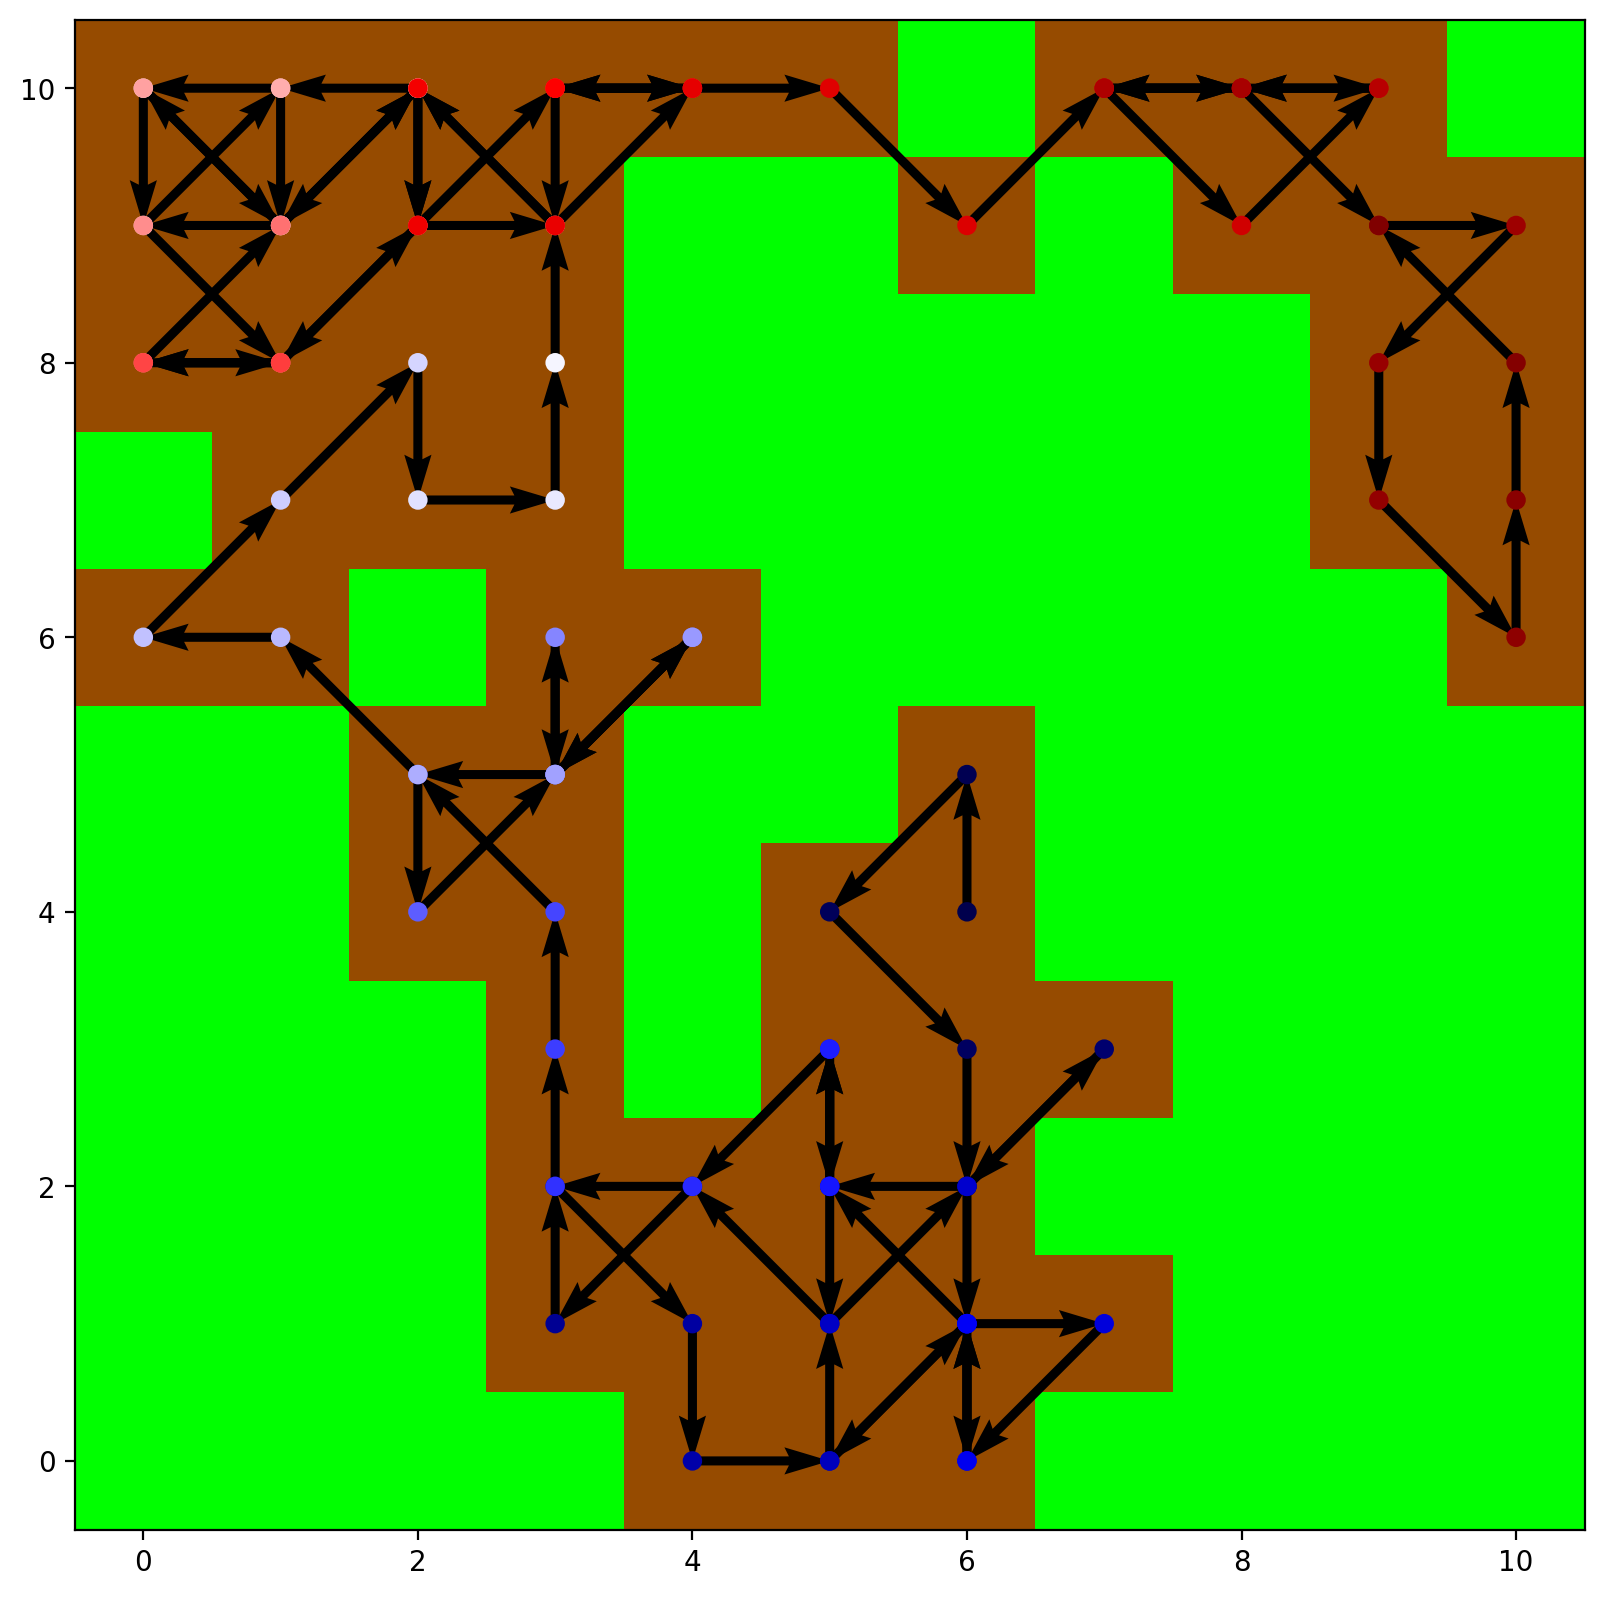

In [187]:
PlotCow(path,field)

In [212]:
# Part C
def AnalyzeCow(gridsize, weight_grass, weight_bare, start_pos, steps_hrs, starv_time_hrs, iters):
    '''
    This function will loop through several iterations of SimulateCow, reporting survivial
    probability, average duration of survival, average % of grass eaten, and histograms that describe
    all of these things

    inputs: 
        gird size: m x n tuple; specifies dimensions of the grid

        weight_grass/weight_bare: interger; specifies the weight with which the cow prefers grass/bare
            patches
        
        start_pos: 2 element tuple: index position where the cow starts

        steps: interger; how many times the cow moves

        starve time: interger; how long the cow can go without eating in hours

        iters: interger; how many runs to move the simulation through
    
    Outputs:
        Prints the survivial chance, number of dead cows, average survival duration, and % grass eaten

        displays histograms of living vs dead cows, duration of survival, and % grass eaten

    '''
    # turn the step_hrs into an interger steps. 1 happens every 40 minutes (20 min of moving and 20 min of resting)
    steps = math.floor(steps_hrs*60/40)

    # initialize our np arrays that hold our variables
    living = np.empty(iters, dtype = bool)

    times = np.empty(iters, dtype = np.float64)

    per_bare = np.empty(iters, np.float64)
    
    #this for loop iterates through SimulateCow and saves our stats
    for i in range(iters):
        path, alive, field, time = SimulateCow(gridsize, weight_grass, weight_bare, start_pos, steps, starv_time_hrs)
        living[i] = alive
        times[i] = time
        # calculate how much of the field is bare
        num_bare = np.count_nonzero(field == 0)
        per_bare[i] = num_bare/field.size*100

    # Convert our arrays into a dataframe for easy manipulation
    cowstats = pd.DataFrame({'living':living, 'times':times, 'per_bare': per_bare})

    # convert the boolean to an interger for calculations
    cowstats['living'] = cowstats['living'].astype(int)

    # I'll keep thinking about this, but here are the basic stats we might be interested in
    per_surv = cowstats['living'].value_counts().loc[1]/len(cowstats)*100

    try:
        dead = cowstats['living'].value_counts().loc[0]
    except KeyError:
        dead = 0
    
    survival_duration = cowstats['times'].mean()

    avg_eaten = cowstats['per_bare'].mean()

    # along with our print statements
    print(f'The percent surviving after the sim is (and roughly the chance of a cow survigin the stay) is {per_surv}.')
    print(f'{dead} cows died during the sim.')
    print(f'The average duration of survival is {round(survival_duration,2)}')
    print(f'The average percent of grass eaten is {round(avg_eaten,2)}')

    # we plot our histograms using matplotlib and seaborn because Seaborn is very pretty
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4), dpi = 200)

    sns.histplot(data = cowstats, x = 'living', ax = ax1)

    sns.histplot(data = cowstats, x = 'times', ax = ax2)
    
    sns.histplot(data = cowstats, x = 'per_bare', ax = ax3)
    fig.suptitle('Cow Histograms')
    fig.tight_layout()

The percent surviving after the sim is (and roughly the chance of a cow survigin the stay) is 100.0.
0 cows died during the sim.
The average duration of survival is 47.33
The average percent of grass eaten is 30.47


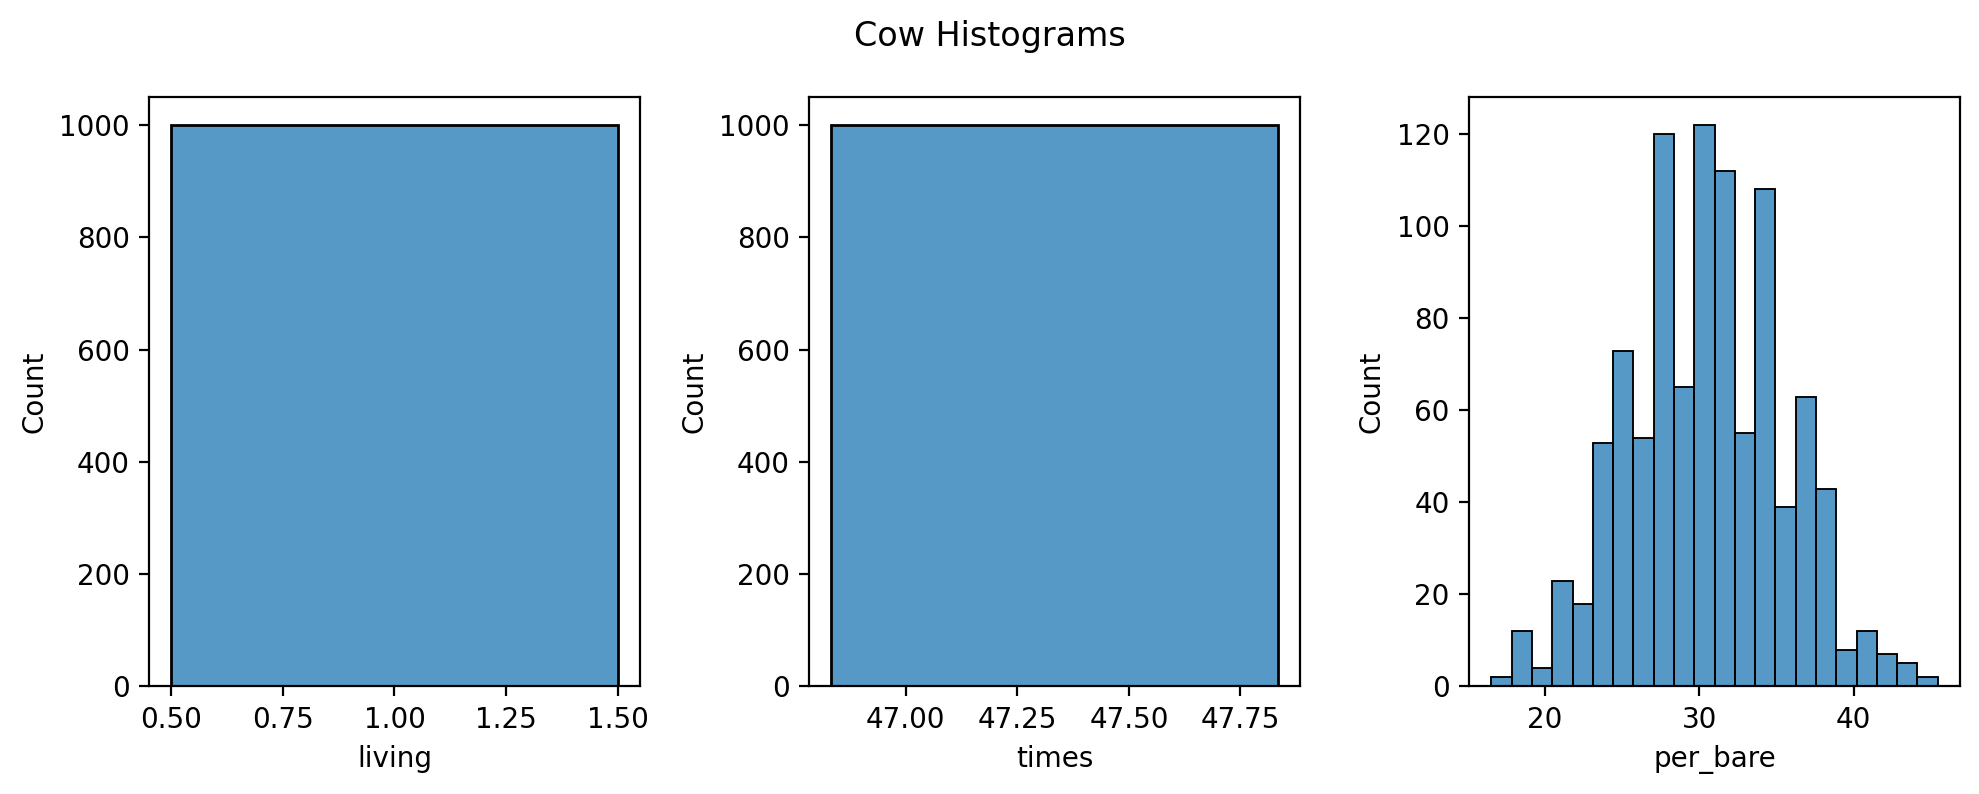

In [213]:
# Part D.1
AnalyzeCow( gridsize=(11, 11),  weight_grass=1,  weight_bare=1,  start_pos=(6,6) , steps_hrs= 48, starv_time_hrs= 24, iters= 1000)

The percent surviving after the sim is (and roughly the chance of a cow survigin the stay) is 100.0.
0 cows died during the sim.
The average duration of survival is 47.33
The average percent of grass eaten is 38.36


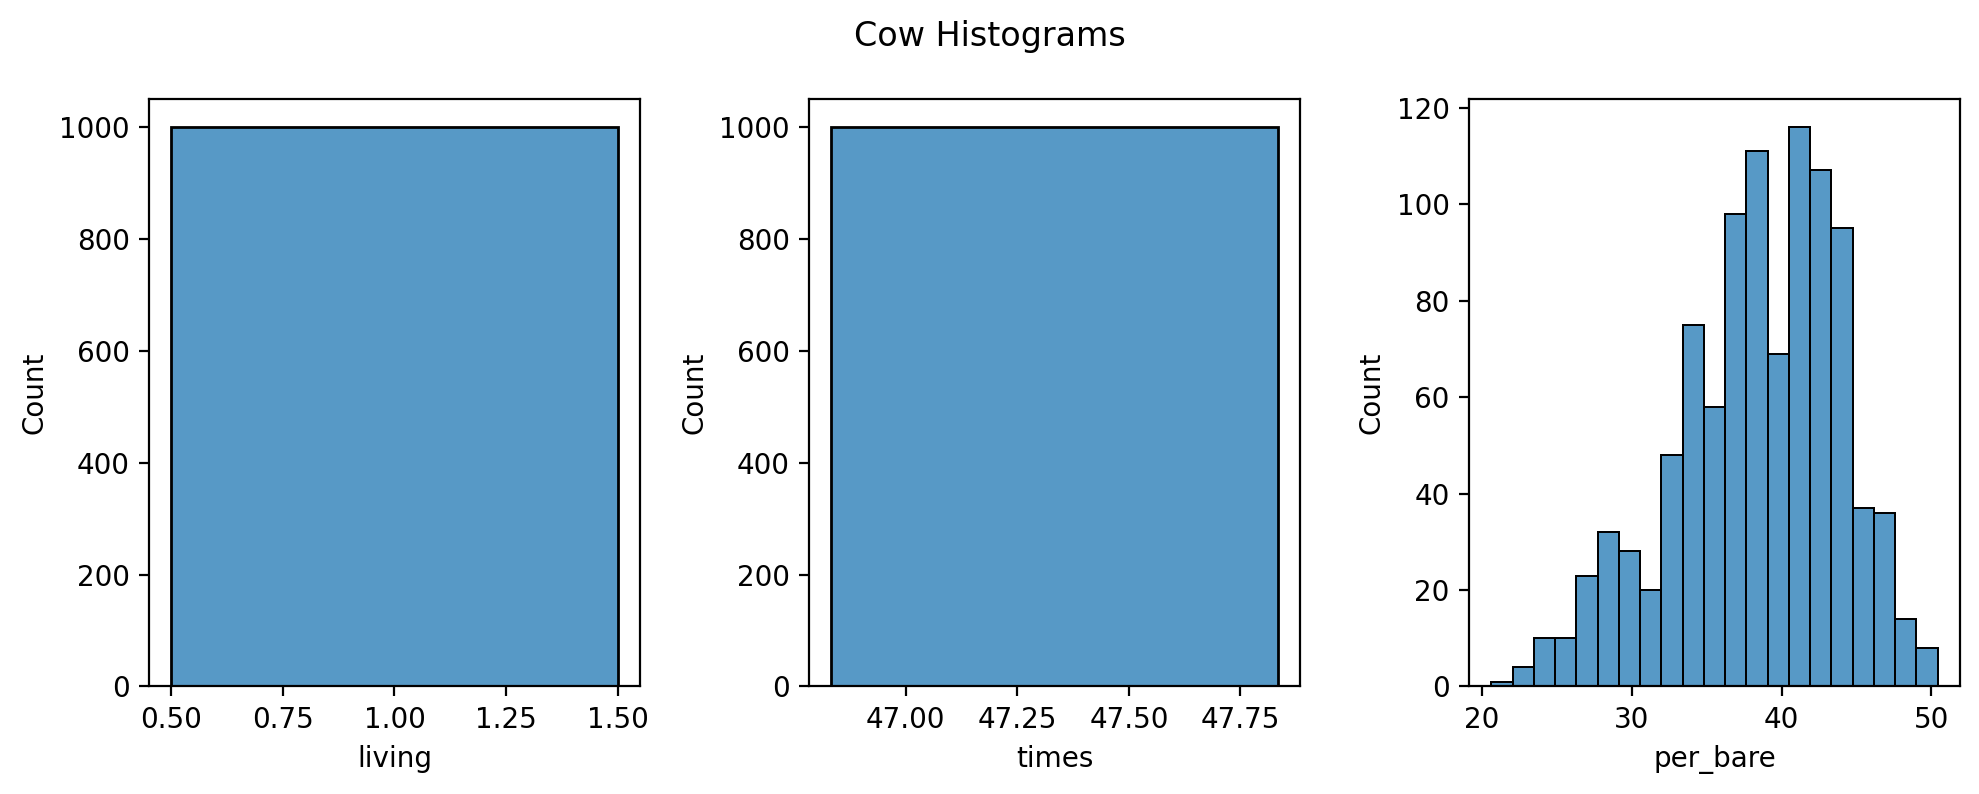

In [214]:
# Part D.2
AnalyzeCow( gridsize=(11, 11),  weight_grass=2,  weight_bare=1,  start_pos=(6,6) , steps_hrs= 48, starv_time_hrs= 24, iters= 1000)